In [1]:
from activations import LeakyRelu, Tanh, Sigmoid

l = [LeakyRelu()]

In [2]:
from VAE import Encoder, Decoder, Discriminator, VAEGANTrainer
from tensorflow.keras.datasets import mnist
import numpy as np

# Инициализация
# Инициализация
# Подготовка данных
def preprocess_data(x):
    x = x.astype('float32') / 255.0
    return x.reshape(x.shape[0], -1)

# Загрузка данных MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = preprocess_data(x_train)

# Инициализация моделей
encoder = Encoder(learning_rate= 1e-6) # Ниже 1e-6 значения kl улаетает \
decoder = Decoder(learning_rate=1e-6)
discriminator = Discriminator(learning_rate=1e-6)

# Обучение
trainer = VAEGANTrainer(encoder, decoder, discriminator)
trainer.train(x_train, batch_size=128, epochs=15)


ValueError: operands could not be broadcast together with shapes (128,784) (128,50) 

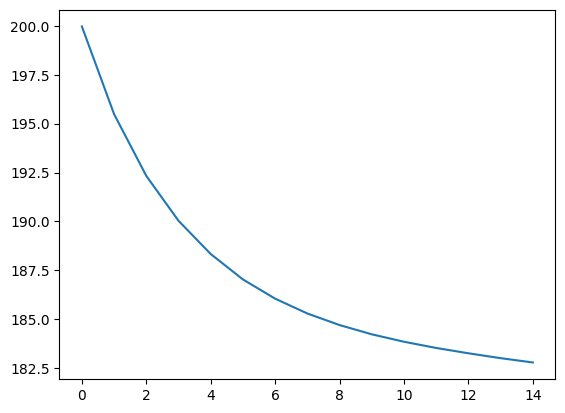

In [3]:
from matplotlib import pyplot as plt

plt.plot(trainer.vae_loss_history)

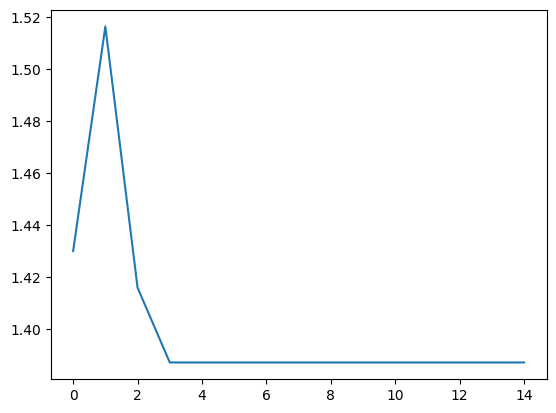

In [4]:
from matplotlib import pyplot as plt

plt.plot(trainer.gan_loss_history)

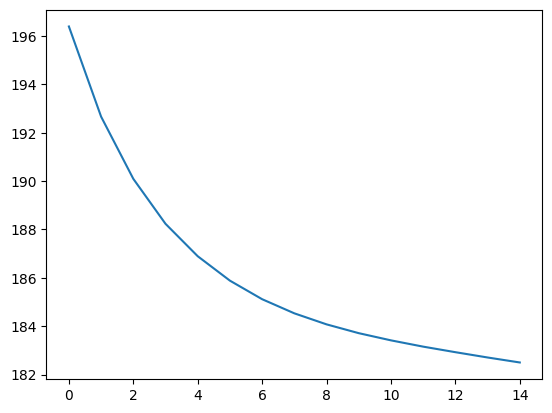

In [9]:
from matplotlib import pyplot as plt

plt.plot(trainer.recon_loss_history)

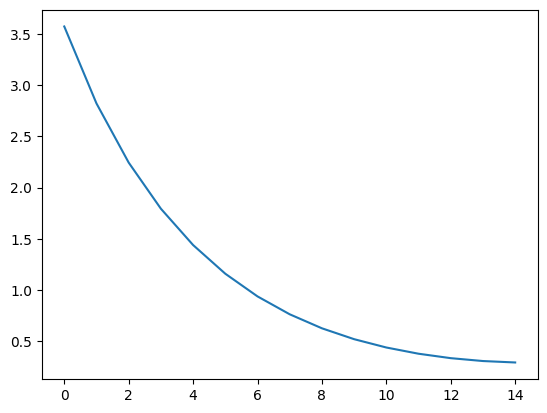

In [5]:
from matplotlib import pyplot as plt

plt.plot(trainer.kl_loss_history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_reconstruction(vae_trainer, x_test, num_images=10):
    """
    Visualize the reconstruction of images by the VAE.
    """
    # Select random images
    idx = np.random.choice(len(x_test), num_images, replace=False)
    original_images = x_test[idx]

    # Get reconstructed images
    reconstructed_images, _, _ = vae_trainer.forward(original_images)

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.show()

def visualize_latent_space(vae_trainer, x_test, y_test):
    """
    Visualize the latent space for a 2D latent dimension.
    """
    # Encode images to latent space
    mu, _ = vae_trainer.encoder.forward(x_test)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='viridis', s=2)
    plt.colorbar(scatter, label="Class")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

def generate_samples(vae_trainer, grid_size=10, latent_range=(-3, 3)):
    """
    Generate images by sampling the latent space.
    """
    # Create a grid of latent space values
    grid_x = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid_y = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)

    # Decode the grid
    generated_images = vae_trainer.decoder.forward(grid)

    # Plot the generated images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    for i in range(grid_size):
        for j in range(grid_size):
            img = generated_images[i * grid_size + j].reshape(28, 28)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.show()

visualize_reconstruction(vae_trainer, x_test)
visualize_latent_space(vae_trainer, x_test, y_test)
generate_samples(vae_trainer)


NameError: name 'vae_trainer' is not defined